In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.vision import *
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(base_dir + 'data/PatternRecog')
#path.mkdir(parents=True, exist_ok=True)


In [0]:
#!ls ./gdrive/My\ Drive/fastai-v3/data/PatternRecog/

In [0]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/data/PatternRecog')

In [0]:
data=pd.read_csv(f"{path}/dress_patterns.csv")


In [0]:
data.iloc[0, -1]

'http://s3-eu-west-1.amazonaws.com/we-attributes/dress/23/5f635c0fa59f4270a6953f67dcddcda3.jpg.png'

In [0]:
#creating seperate folder for each category and saving each file
import requests
from os.path import join,expanduser
import os

home = path
for index, row in data.iterrows():
    url = row['image_url']
    file_name = url.split('/')[-1]
    r = requests.get(url)
    filepath = join(home,row['category'])
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath = join(filepath, file_name)
        # print(filepath)
    if r.status_code == 200:
        with open(filepath, "wb") as f:
            f.write(r.content)

In [0]:
#creating databunch of the images and spliting into training and validation set
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
PatternRecog
  if getattr(ds, 'warn', False): warn(ds.warn)


In [0]:
data.classes

['OTHER',
 'animal',
 'cartoon',
 'chevron',
 'floral',
 'geometry',
 'houndstooth',
 'ikat',
 'letter_numb',
 'plain',
 'polka dot',
 'scales',
 'skull',
 'squares',
 'stars',
 'stripes',
 'tribal']

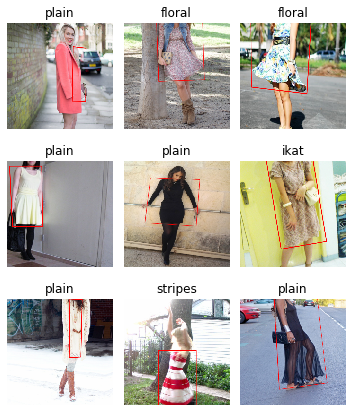

In [0]:
data.show_batch(rows=3, figsize=(5,6))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['OTHER',
  'animal',
  'cartoon',
  'chevron',
  'floral',
  'geometry',
  'houndstooth',
  'ikat',
  'letter_numb',
  'plain',
  'polka dot',
  'scales',
  'skull',
  'squares',
  'stars',
  'stripes',
  'tribal'],
 17,
 10248,
 2560)

In [0]:
#loading cnn model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 47.5MB/s]


In [0]:
#fitting cycles into model
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.126489,1.428200,0.337500,23:26
1,1.431507,1.166842,0.290234,04:40
2,1.205996,1.081476,0.282813,04:42
3,1.033065,1.069835,0.278125,04:42


In [0]:
learn.save('stage-1')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


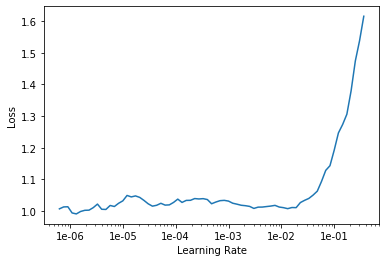

In [0]:
learn.recorder.plot()

In [0]:
#loading a random image
img=open_image(f"{path}/floral.jpg")

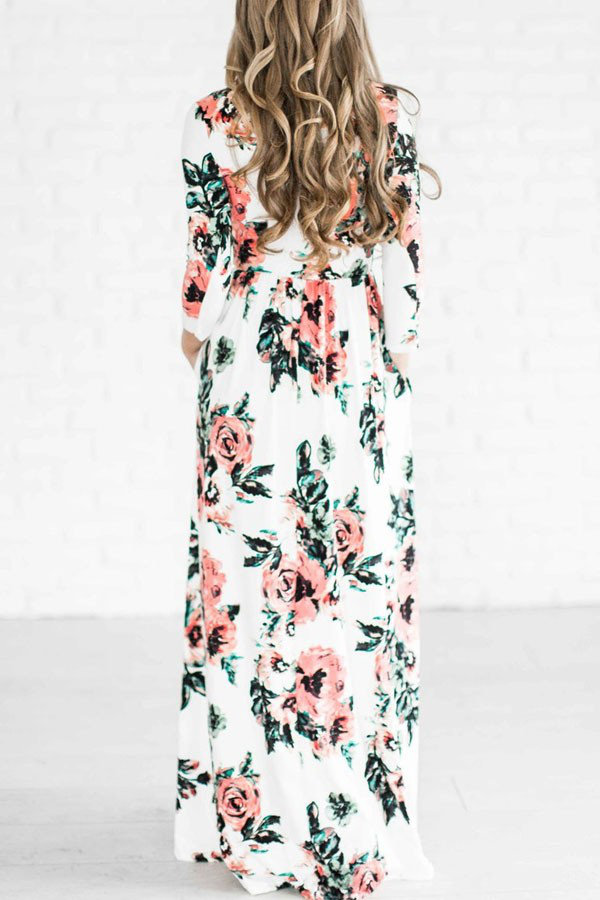

In [0]:
img

In [0]:
#trying to predict the category of the image
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category floral

In [0]:
#giving out all the images of the predicted category
import glob
import cv2
def similardress(img):
  pred_class=learn.predict(img)
  path1 = Path(str(path) + '/' + str(pred_class))
  for img in glob.glob(str(path1)):
    plt.imshow(img)

In [0]:
learn.export()